In [1]:
import numpy as np
import PyDSTool as dst
from PyDSTool.Toolbox import phaseplane as pp
from scipy.optimize import fsolve

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython.display import display, Math

In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [4]:
mpl.rcParams['figure.figsize'] = [6, 4]
mpl.rcParams['font.size'] = 16
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 8

In [5]:
figdir = './figures/'
plt.rc('text', usetex=True)

# Carryover of a saddle-node bifurcation
# Application: Pathway to diabetes

The model of $\beta$-cell mass, insulin $I$ and glucose $G$ is
$$
\begin{aligned}
    \dot G &= R_{0} - (E_{GO} + S_{I}I)G, \\
    \dot I &= \frac{\beta \sigma G^2}{\alpha + G^2} - kI,\\
    \dot \beta &= (-d_{0} + r_1 G - r_{2}G^2)\beta,
\end{aligned}
$$
where $R_{0}$ is the net rate of glucose production at zero glucose, $E_{GO}$ is the total glucose effectiveness at zero insulin, $S_{I}$ is the total insulin sensitivity, $\sigma$ maximal rate of insulin secretion, $\alpha$ is the half-saturation rate of insulin secretion, $k$ clearance rate, $d_0$ is the death rate at zero glucose, and $r_1$ and $r_2$ are death rate constants.  


## 1. Bifurcation diagram

We can construct the bifurcation diagram using continuation and the `PyDSTool` library of python.

In [51]:
# dynamical system
Gstr = 'R0 - (EG0 + SI*I)*G'
Istr = 'beta*sigma*G**2/(alpha + G**2) - k*I'
betastr = '(- d0 + r1*G - r2*G**2)*beta'
params = {'R0':864, 'EG0':1.44, 'SI':0.72, 'sigma':43.2, 'alpha':20000., 
          'k':432., 'd0': 0.06, 'r1':0.84e-3, 'r2':0.24e-5}
ics = {'G': 0, 'I':0.4, 'beta':0.1}
DSargs = dst.args(name='Glucose')
DSargs.pars = params
DSargs.tdata = [0, 2]
DSargs.pdomain = {'SI': [0, 1], 'r1': [0, 0.01]}
DSargs.xdomain = {'G': [-10, 1000], 'I':[-10, 100], 'beta':[0, 3000]}
DSargs.varspecs = {'G': Gstr, 'I': Istr, 'beta':betastr}
DSargs.ics = ics
DS = dst.Generator.Vode_ODEsystem(DSargs)

In [52]:
fps = pp.find_fixedpoints(DS, n=4, eps=1e-8)
fps

({'G': 600.0000000000001, 'I': -1.0711692271868095e-36, 'beta': 0.0},
 {'G': 249.9999999998573, 'I': 2.8000000000015253, 'beta': 36.96000000002679},
 {'G': 100.00000000065624, 'I': 9.99999999992368, 'beta': 299.99999999700634})

In [61]:
# bifurcation diagram for s
# first branch
PC = dst.ContClass(DS)
name1 = 'EQ1'
PCargs = dst.args(name=name1)
PCargs.type = 'EP-C'
PCargs.initpoint = fps[1]
PCargs.freepars = ['r1']
PCargs.StepSize = 1e-3
PCargs.MaxNumPoints = 3000
PCargs.MaxStepSize = 1e-2
PCargs.MinStepSize = 1e-6
PCargs.MaxTestIters = 20
PCargs.LocBifPoints = 'all'
PCargs.SaveEigen = True
PCargs.StopAtPoints = ['B']
PCargs.verbosity = 2

PC.newCurve(PCargs)
PC.curves[name1].backward()
PC.curves[name1].forward()

# second branch
name2 = 'EQ2'
PCargs = dst.args(name=name2)
PCargs.type = 'EP-C'
PCargs.initpoint = fps[0]
PCargs.freepars = ['r1']
PCargs.StepSize = 1e-3
PCargs.MaxNumPoints = 2000
PCargs.MaxStepSize = 1e-2
PCargs.MinStepSize = 1e-6
PCargs.MaxTestIters = 20
PCargs.LocBifPoints = 'all'
PCargs.SaveEigen = True
PCargs.StopAtPoints = ['B']
PCargs.verbosity = 2

PC.newCurve(PCargs)
PC.curves[name2].backward()
PC.curves[name2].forward()

Maximum test function iterations reached.

B Point found 
0 : 
G  =  600.0
I  =  0.0
beta  =  0.0
r1  =  9.404261222882388e-05

Maximum test function iterations reached.

B Point found 
0 : 
G  =  600.0
I  =  0.0
beta  =  0.0
r1  =  0.004899222809092302



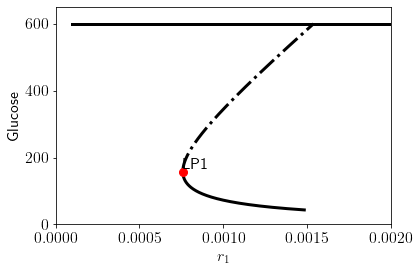

In [54]:
PC['EQ1'].display(('r1', 'G'), stability=True, linewidth=3)
PC['EQ2'].display(('r1', 'G'), stability=True, linewidth=3)
PC.plot.fig1.toggleAll('off', bytype=['P','B'])
PC.plot.fig1.axes1.axes.set_xlabel('$r_{1}$', fontsize=16)
PC.plot.fig1.axes1.axes.set_xlim((0.0, 0.002))
PC.plot.fig1.axes1.axes.set_ylabel('Glucose', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylim((0.0, 650))
PC.plot.fig1.axes1.axes.set_title('')
plt.savefig(figdir + 'ApplicationDiabetes.pdf', bbox_inches='tight')
plt.show()

From here we can follow the bifurcation point varying both parameters $s$ and $r$.

In [55]:
# Two-parameter bifurcation
namefold1 = 'F01'
PCargs = dst.args(name=namefold1)
PCargs.type = 'LP-C'
PCargs.initpoint = 'EQ1:LP1'
PCargs.freepars = ['r1', 'SI']
PCargs.StepSize = 1e-2
PCargs.MaxNumPoints = 2000
PCargs.MaxStepSize = 5e-1
PCargs.MinStepSize = 1e-4
PCargs.SaveEigen = True
PCargs.SaveJacobian = True
PCargs.LocBifPoints = 'all'
PCargs.StopAtPoints = ['B']
PCargs.verbosity = 0
PC.newCurve(PCargs)
PC.curves[namefold1].forward()
PC.curves[namefold1].backward()

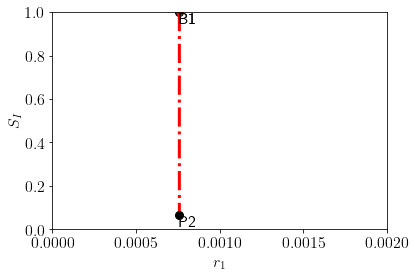

In [60]:
PC[namefold1].display(('r1', 'SI'), stability=True, linewidth=3)
# PC.plot.toggleLabels('off')
# PC.plot.fig1.toggleAll('off', bytype=['P', 'BT', 'CP'])
PC.plot.fig1.axes1.axes.set_xlim((0.0, 0.002))
PC.plot.fig1.axes1.axes.set_xlabel('$r_{1}$', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylim((0.0, 1))
PC.plot.fig1.axes1.axes.set_ylabel('$S_{I}$', fontsize=16)
PC.plot.fig1.axes1.axes.set_title('')
plt.savefig(figdir + 'ApplicationDiabetesTwoParBif.pdf', bbox_inches='tight')
plt.show()

## 3. Turn $s$ into a variable

Suppose that we turn $s$ into a variable to get the system
$$
\begin{aligned}
    \dot x &= s - rx + \frac{x^{2}}{1+x^{2}}, \\
    \dot s &= a - bs.
\end{aligned}
$$

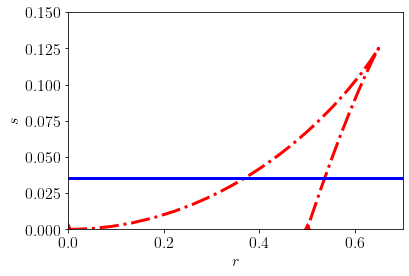

In [18]:
PC[namefold1].display(('r', 's'), stability=True, linewidth=3)
PC.plot.toggleLabels('off')
PC.plot.fig1.toggleAll('off', bytype=['P','BT','CP'])
PC.plot.fig1.axes1.axes.set_xlim((0.0, 0.7))
PC.plot.fig1.axes1.axes.set_xlabel('$r$', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylim((0.0, 0.15))
PC.plot.fig1.axes1.axes.set_ylabel('$s$', fontsize=16)
PC.plot.fig1.axes1.axes.set_title('')
plt.axhline(y=6/169, lw=3, color='b')
plt.savefig(figdir + 'ApplicationGenTwoParBifurcation2.pdf', bbox_inches='tight')
plt.show()

In [19]:
# dynamical system
xstr = 's-r*x+x**2/(1+x**2)'
sstr = 'a-b*s'
params = {'r': 125/338, 'a': 6/169, 'b': 1}
ics = {'x': 1, 's': 0}
DSargs = dst.args(name='GenActivation')
DSargs.pars = params
DSargs.tdata = [0, 2]
DSargs.pdomain = {'r': [0, 0.8]}
DSargs.xdomain = {'x': [0, 10.0], 's': [0, 0.2]}
DSargs.varspecs = {'x': xstr, 's': sstr}
DSargs.ics = ics
DS = dst.Generator.Vode_ODEsystem(DSargs)

In [20]:
fps = pp.find_fixedpoints(DS, n=4, eps=1e-8)
fps

({'s': 0.03550295857988166, 'x': 0.1999999971740397},
 {'s': 0.03550295857988166, 'x': 2.4})

In [21]:
PC = dst.ContClass(DS)
name1 = 'EQ1'
PCargs = dst.args(name=name1)
PCargs.type = 'EP-C'
PCargs.initpoint = {'x': 0, 's': 6/169}
PCargs.freepars = ['r']
PCargs.StepSize = 1e-3
PCargs.MaxNumPoints = 800
PCargs.MaxStepSize = 5e-2
PCargs.MinStepSize = 1e-6
PCargs.MaxTestIters = 40
PCargs.LocBifPoints = 'all'
PCargs.SaveEigen = True
PCargs.StopAtPoints = ['B']
PCargs.verbosity = 2

PC.newCurve(PCargs)
PC.curves[name1].backward()
PC.curves[name1].forward()


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000000
  |transpose(A)p| = 0.000000

LP Point found 
0 : 
s  =  0.03550295857988166
x  =  0.20000020347230507
r  =  0.3698224852072626

Eigenvalues = 

     (0.000000,0.000000)
     (-1.000000,0.000000)


a = 0.7823163948814567


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000000
  |transpose(A)p| = 0.000000

LP Point found 
0 : 
s  =  0.03550295857988166
x  =  0.925820322394435
r  =  0.536866093359218

Eigenvalues = 

     (-0.000000,0.000000)
     (-1.000000,0.000000)


a = 0.24533457686446805

B Point found 
0 : 
s  =  0.03550295857988166
x  =  10.00000000637913
r  =  0.10256019678391338

B Point found 
0 : 
s  =  0.03550295857988166
x  =  0.04715162468390597
r  =  0.8000000541524838



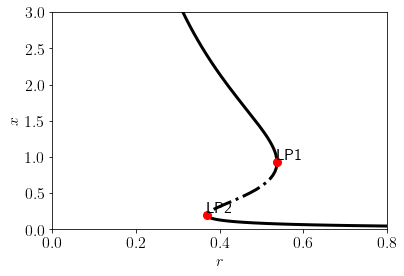

In [22]:
PC['EQ1'].display(('r', 'x'), stability=True, linewidth=3)
PC.plot.fig1.toggleAll('off', bytype=['P','B'])
PC.plot.fig1.axes1.axes.set_xlim((0, 0.8))
PC.plot.fig1.axes1.axes.set_xlabel('$r$', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylim((0, 3.0))
PC.plot.fig1.axes1.axes.set_ylabel('$x$', fontsize=16)
PC.plot.fig1.axes1.axes.set_title('')
# plt.savefig(figdir + 'ApplicationGenExtended2Bifurcation.pdf', bbox_inches='tight')
plt.show()